In [1]:
import pandas as pd
from prophet import Prophet
#from fbprophet import Prophet

In [2]:
df = pd.read_csv("Twitter_May_Aug_2014_TerrorSecurity_resolved.txt", sep=" ", header=None)
df.columns = ['dateTime', 'mentionedEntity1', 'mentionedEntity2']
df

,dateTime,mentionedEntity1,mentionedEntity2
0,05:02:2014:20:15:22,statusid_462321880817745921,userid_831528001
1,05:02:2014:20:15:22,statusid_462321880817745921,userid_11134252
2,05:02:2014:20:15:22,statusid_462321880817745921,userid_20733972
3,05:02:2014:20:15:22,statusid_462321880817745921,benghazi
4,05:02:2014:20:15:22,statusid_462321880817745921,gop_benghazi
...,...,...,...
2601829,08:01:2014:04:19:58,userid_1271158584,chiltern_firehouse
2601830,08:01:2014:04:19:58,userid_1271158584,london
2601831,08:01:2014:04:19:58,userid_1271158584,july
2601832,08:01:2014:04:19:58,userid_1537804958,http://pbs.twimg.com/media/bt7phzcceaa7bm5.jpg


In [3]:
from sklearn.preprocessing import LabelEncoder

Just going to observe anomalies in May, since there are so many data points.

In [4]:
mask = (df['dateTime'] > '05:02:2014:20:15:22') & (df['dateTime'] <= '05:31:2014:23:59:00')
df_may_only = df.loc[mask]
df_may_only

,dateTime,mentionedEntity1,mentionedEntity2
15,05:02:2014:20:16:10,userid_1257381576,#endoftheworld
16,05:02:2014:20:16:10,userid_1257381576,userid_30070583
17,05:02:2014:20:16:10,userid_1257381576,rogee
18,05:02:2014:20:16:10,userid_1257381576,caffeine_cowboy
19,05:02:2014:20:16:10,#endoftheworld,userid_30070583
...,...,...,...
393225,05:31:2014:23:58:14,statusid_472889558406029312,userid_1401272976
393226,05:31:2014:23:58:14,userid_97722200,userid_1401272976
393227,05:31:2014:23:58:16,userid_410687075,http://t.co/yrtuek7k9v
393228,05:31:2014:23:58:16,userid_410687075,sonny


In [5]:
#label encoding first entity
pd.options.mode.chained_assignment = None
le = LabelEncoder()
df_may_only.iloc[:,1] = le.fit_transform(df_may_only.iloc[:,1])
df_may_only.head()

,dateTime,mentionedEntity1,mentionedEntity2
15,05:02:2014:20:16:10,26433,#endoftheworld
16,05:02:2014:20:16:10,26433,userid_30070583
17,05:02:2014:20:16:10,26433,rogee
18,05:02:2014:20:16:10,26433,caffeine_cowboy
19,05:02:2014:20:16:10,2247,userid_30070583


In [6]:
#label encoding first entity
le = LabelEncoder()
df_may_only.iloc[:,2] = le.fit_transform(df_may_only.iloc[:,2])
df_may_only.head()

,dateTime,mentionedEntity1,mentionedEntity2
15,05:02:2014:20:16:10,26433,2443
16,05:02:2014:20:16:10,26433,36301
17,05:02:2014:20:16:10,26433,27625
18,05:02:2014:20:16:10,26433,10504
19,05:02:2014:20:16:10,2247,36301


In [7]:
import numpy as np
entity1_array = df_may_only[['mentionedEntity1']].to_numpy()
entity1_array = entity1_array.flatten()
entity1_array

array([26433, 26433, 26433, ..., 44383, 44383, 17633])

In [8]:
#commented out so random entities don't change
#random_entity1_array = [np.random.choice(len(entity1_array), size=5000, replace=False)]
#random_entity1_array = np.asarray(random_entity1_array)
#random_entity1_array = random_entity1_array.flatten()

In [61]:
#random entities that were generated 4/25 are saved in random_entities.txt
random_entity1_array = np.loadtxt("random_entities.txt").reshape(5000)

In [62]:
temp_df1 = pd.DataFrame(columns=['dateTime','mentionedEntity1'])
data = []

for entity in df_may_only.iterrows():
    if entity[1][1] in random_entity1_array:
        data.append((entity[1][0], entity[1][1]))

temp_df2 = pd.DataFrame(data , columns=['dateTime','mentionedEntity1'])
may_random = pd.concat([temp_df1, temp_df2], ignore_index=True)

may_random

,dateTime,mentionedEntity1
0,2014-05-12,25681
1,2014-05-12,25681
2,2014-05-12,25681
3,2014-05-12,25681
4,2014-05-12,25681
...,...,...
4219,2014-05-31,32844
4220,2014-05-31,32844
4221,2014-05-31,11622
4222,2014-05-31,11622


In [10]:
df_may_only['dateTime'] = pd.to_datetime(df_may_only['dateTime'], format="%m:%d:%Y:%H:%M:%S")

# change dateTime column to just dates for visualizations
df_may_only['dateTime'] = df_may_only['dateTime'].dt.date

entity1_ct_df = (df_may_only.reset_index()
          .groupby(['dateTime','mentionedEntity1'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

entity1_ct_df.pop("mentionedEntity2")
entity1_ct_df


,dateTime,mentionedEntity1,ct
0,2014-05-02,1009,2
1,2014-05-02,1598,1
2,2014-05-02,2247,3
3,2014-05-02,6547,4
4,2014-05-02,6883,3
...,...,...,...
64639,2014-05-31,52238,1
64640,2014-05-31,52256,1
64641,2014-05-31,52260,166
64642,2014-05-31,52265,1


In [11]:
may_random['dateTime'] = pd.to_datetime(may_random['dateTime'], format="%m:%d:%Y:%H:%M:%S")

# change dateTime column to just dates for visualizations
may_random['dateTime'] = may_random['dateTime'].dt.date

random_entity1_ct_df = (may_random.reset_index()
          .groupby(['dateTime','mentionedEntity1'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )

random_entity1_ct_df

,dateTime,mentionedEntity1,ct
0,2014-05-12,383,105
1,2014-05-12,1345,64
2,2014-05-12,3608,13
3,2014-05-12,5182,2
4,2014-05-12,17917,1
...,...,...,...
856,2014-05-31,42442,14
857,2014-05-31,43451,3
858,2014-05-31,45034,4
859,2014-05-31,51430,3


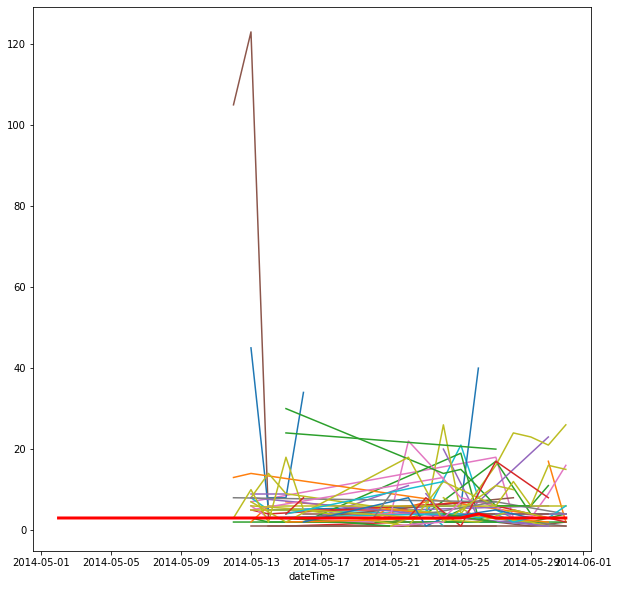

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

count = 1
# key gives the group name (i.e. category), data gives the actual values
for key, data in random_entity1_ct_df.groupby('mentionedEntity1'):
    data.plot(x='dateTime', y='ct', ax=ax)
    
#adding median dailing count for all entities
entity1_ct_df.groupby(entity1_ct_df["dateTime"])["ct"].median().plot(kind='line',
                                                                     rot=0, ax=ax, linewidth=3, color='red')

ax.get_legend().remove()

In [16]:
import plotly.express as px

fig = px.line(random_entity1_ct_df, x ="dateTime", y ="ct", color="mentionedEntity1")
    #print(data)
fig.show()

From this graph we can determine that the mentioned entities 383, 8101, and 24742 may have anomalies. Now let's run prophet.

In [40]:
temp_df1 = pd.DataFrame(columns=['dateTime','ct'])
data = []

for entity in random_entity1_ct_df.iterrows():
    if entity[1][1] == 383:
        data.append((entity[1][0], entity[1][2]))

temp_df2 = pd.DataFrame(data , columns=['dateTime','ct'])
entity383_df = pd.concat([temp_df1, temp_df2], ignore_index=True)

In [41]:
import datetime
missing_dates = [(datetime.date(2014, 5, 15), 0), (datetime.date(2014, 5, 16), 0), 
                 (datetime.date(2014, 5, 17), 0), (datetime.date(2014, 5, 18), 0),
                 (datetime.date(2014, 5, 19), 0), (datetime.date(2014, 5, 20), 0),
                 (datetime.date(2014, 5, 21), 0), (datetime.date(2014, 5, 22), 0),
                 (datetime.date(2014, 5, 23), 0), (datetime.date(2014, 5, 24), 0),
                 (datetime.date(2014, 5, 25), 0), (datetime.date(2014, 5, 26), 0),
                 (datetime.date(2014, 5, 27), 0), (datetime.date(2014, 5, 28), 0),
                 (datetime.date(2014, 5, 29), 0), (datetime.date(2014, 5, 30), 0),
                 (datetime.date(2014, 5, 31), 0)]

temp_df3 = pd.DataFrame(missing_dates , columns=['dateTime','ct'])
entity383_df = pd.concat([entity383_df, temp_df3], ignore_index=True)

In [44]:
temp_df1 = pd.DataFrame(columns=['dateTime','ct'])
data = []

for entity in random_entity1_ct_df.iterrows():
    if entity[1][1] == 8101:
        data.append((entity[1][0], entity[1][2]))

temp_df2 = pd.DataFrame(data , columns=['dateTime','ct'])
entity8101_df = pd.concat([temp_df1, temp_df2], ignore_index=True)

In [49]:
missing_dates = [(datetime.date(2014, 5, 12), 0), (datetime.date(2014, 5, 16), 0), 
                 (datetime.date(2014, 5, 17), 0), (datetime.date(2014, 5, 18), 0),
                 (datetime.date(2014, 5, 19), 0), (datetime.date(2014, 5, 20), 0),
                 (datetime.date(2014, 5, 21), 0), (datetime.date(2014, 5, 22), 0)]

temp_df3 = pd.DataFrame(missing_dates , columns=['dateTime','ct'])
entity8101_df = pd.concat([entity8101_df, temp_df3], ignore_index=True)

entity8101_df = entity8101_df.sort_values(by='dateTime')

In [46]:
temp_df1 = pd.DataFrame(columns=['dateTime','ct'])
data = []

for entity in random_entity1_ct_df.iterrows():
    if entity[1][1] == 24742:
        data.append((entity[1][0], entity[1][2]))

temp_df2 = pd.DataFrame(data , columns=['dateTime','ct'])
entity24742_df = pd.concat([temp_df1, temp_df2], ignore_index=True)

In [48]:
missing_dates = [(datetime.date(2014, 5, 12), 0), (datetime.date(2014, 5, 15), 0), 
                 (datetime.date(2014, 5, 16), 0), (datetime.date(2014, 5, 17), 0),
                 (datetime.date(2014, 5, 18), 0), (datetime.date(2014, 5, 19), 0),
                 (datetime.date(2014, 5, 23), 0), (datetime.date(2014, 5, 24), 0),
                 (datetime.date(2014, 5, 26), 0)]

temp_df3 = pd.DataFrame(missing_dates , columns=['dateTime','ct'])
entity24742_df = pd.concat([entity24742_df, temp_df3], ignore_index=True)

entity24742_df = entity24742_df.sort_values(by='dateTime')

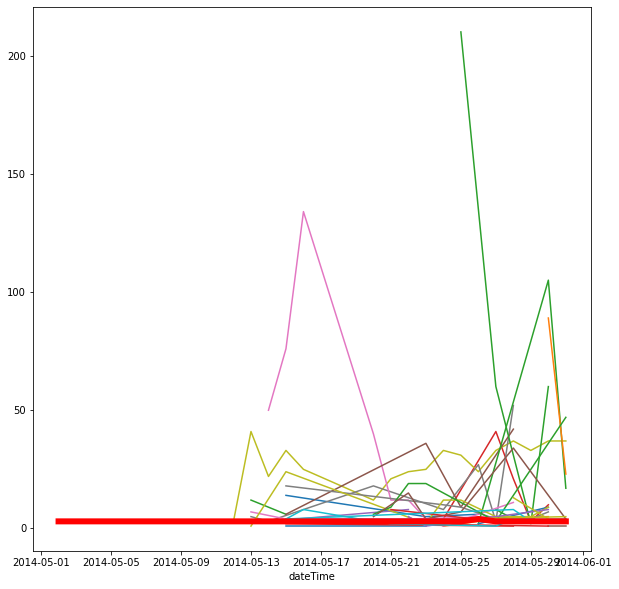

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

count = 1
# key gives the group name (i.e. category), data gives the actual values
for key, data in entity1_ct_df.groupby('mentionedEntity1'):
    data.plot(x='dateTime', y='ct', ax=ax)
    if count == 200:
        break
    count = count + 1
    
#adding median dailing count for all entities
entity1_ct_df.groupby(entity1_ct_df["dateTime"])["ct"].median().plot(kind='line',
                                                                     rot=0, ax=ax, linewidth=6, color='red')

ax.get_legend().remove()

#### Where to go from here
1. Make plots of current data
2. Run prophet and detect anomalies
3. Verify/Evaluate results